In [1]:
#Model B
# CNN with Deeper Architecture and Regularization
# Uses Augmentation for training
# Uses Deeper Model with BatchNorm and Droput and GAP
# Uses Optimizer Weight Decay for Regularization

In [2]:
import os, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
# Paths and Loading Splits
DATASET_DIRECTORY = r"/content/sample_data/natural_images"
SPLIT_FILE = "splits.npz"

IMAGE_SIZE = 160
BATCH_SIZE = 32

EPOCHS = 18
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

NUM_WORKERS = 0
PIN_MEMORY = False

MAX_TRAIN_BATCHES = None


In [4]:
#Load Data Splits
splits = np.load(SPLIT_FILE)
train_index = splits["train_idx"]
validation_index   = splits["val_idx"]
test_index  = splits["test_idx"]
print("Loaded split sizes:", len(train_index), len(validation_index), len(test_index))


Loaded split sizes: 4829 1034 1036


In [5]:
#Dataset Wrapper
class SubsetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.dataset[self.indices[i]]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

def subset_with_transform(data_dir, indices, transform):
    base = ImageFolder(root=data_dir)
    return SubsetWithTransform(base, indices, transform=transform)

In [6]:
#Transform
train_tfms_B = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

base_ds_eval = datasets.ImageFolder(DATASET_DIRECTORY, transform=eval_tfms)
class_names = base_ds_eval.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [7]:
#Subsets and DataLoaders
train_dataset = subset_with_transform(DATASET_DIRECTORY, train_index, train_tfms_B)
validation_dataset   = subset_with_transform(DATASET_DIRECTORY, validation_index, eval_tfms)
test_dataset  = subset_with_transform(DATASET_DIRECTORY, test_index, eval_tfms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
validation_loader   = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


In [8]:
#Deeper Architecture CNN Model with BatchNorm, Dropout, and Global Average Pooling
class DeeperRegCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.4):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )

        self.b1 = block(3, 32)
        self.b2 = block(32, 64)
        self.b3 = block(64, 128)
        self.b4 = block(128, 256)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.gap(x)
        return self.head(x)

model = DeeperRegCNN(num_classes, dropout=0.4).to(device)

In [9]:
#Training and Evaluation Functions
def run_epoch(model, loader, optimizer=None, max_batches=None):
    is_train = optimizer is not None
    model.train(is_train)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_correct, total_n = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = loss_fn(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        logits = model(x.to(device))
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p)
        ys.extend(y.numpy())
    return np.array(ys), np.array(preds)

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.show()


Epoch 01 | train loss: 0.8745 / train acc: 0.6948 | validation loss: 1.1837 / validation acc: 0.6025
Epoch 02 | train loss: 0.5566 / train acc: 0.7944 | validation loss: 0.6645 / validation acc: 0.7824
Epoch 03 | train loss: 0.4857 / train acc: 0.8217 | validation loss: 0.5183 / validation acc: 0.8375
Epoch 04 | train loss: 0.4174 / train acc: 0.8457 | validation loss: 0.4154 / validation acc: 0.8530
Epoch 05 | train loss: 0.3528 / train acc: 0.8621 | validation loss: 0.3459 / validation acc: 0.8588
Epoch 06 | train loss: 0.3535 / train acc: 0.8691 | validation loss: 0.5285 / validation acc: 0.8414
Epoch 07 | train loss: 0.3324 / train acc: 0.8786 | validation loss: 0.3151 / validation acc: 0.8878
Epoch 08 | train loss: 0.3025 / train acc: 0.8917 | validation loss: 0.5264 / validation acc: 0.7930
Epoch 09 | train loss: 0.2798 / train acc: 0.8929 | validation loss: 0.4033 / validation acc: 0.8482
Epoch 10 | train loss: 0.2765 / train acc: 0.8969 | validation loss: 0.3596 / validation ac

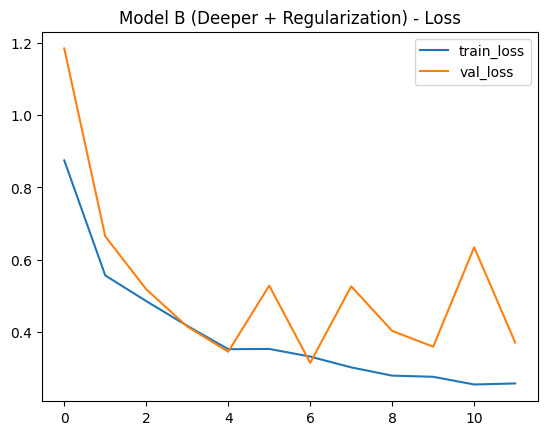

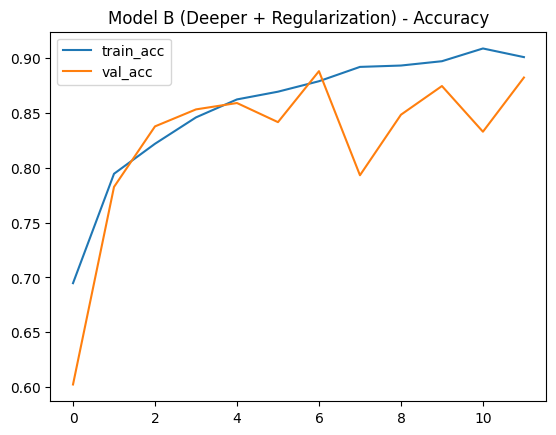

In [11]:
#Training with Weight Decay
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = -1
best_state = None
patience = 5
bad_epochs = 0

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=optimizer, max_batches=MAX_TRAIN_BATCHES)
    va_loss, va_acc = run_epoch(model, validation_loader, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1

    print(f"Epoch {ep:02d} | train loss: {tr_loss:.4f} / train acc: {tr_acc:.4f} | validation loss: {va_loss:.4f} / validation acc: {va_acc:.4f}")

    if bad_epochs >= patience:
        print("Early stopping...")
        break

model.load_state_dict(best_state)
plot_history(history, "Model B (Deeper + Regularization)")


Model B Test Accuracy: 0.8716
Confusion Matrix:
 [[ 83   0   9   1   5   0   2   0]
 [  0 141   1   5   3   0   1   0]
 [  2   0  99  47   1   1   0   6]
 [  2   1  23  73   4   0   0   4]
 [  0   0   1   3 133   0   1   0]
 [  0   0   0   1   1 131   0   0]
 [  1   0   0   0   5   0 118   0]
 [  0   0   0   1   1   0   0 125]]

Classification Report:

              precision    recall  f1-score   support

    airplane       0.94      0.83      0.88       100
         car       0.99      0.93      0.96       151
         cat       0.74      0.63      0.69       156
         dog       0.56      0.68      0.61       107
      flower       0.87      0.96      0.91       138
       fruit       0.99      0.98      0.99       133
   motorbike       0.97      0.95      0.96       124
      person       0.93      0.98      0.95       127

    accuracy                           0.87      1036
   macro avg       0.87      0.87      0.87      1036
weighted avg       0.88      0.87      0.87      

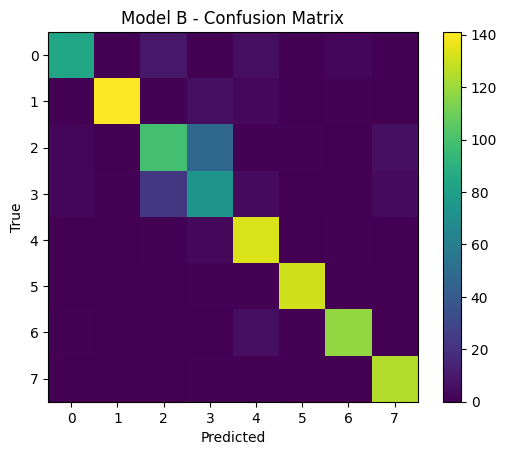

In [ ]:
# Test Metrics
y_true, y_pred = predict_all(model, test_loader)
test_acc = (y_true == y_pred).mean()
print("Model B Test Accuracy:", round(float(test_acc), 4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure()
plt.imshow(cm)
plt.title("Model B - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

